# HCDS-A1-DATA-CURATION

### Rahul R Birmiwal

### Introduction

The purpose of this report is to analyze Wikipedia traffic from various sources -- mobile, desktop, etc -- between Jan 2008 and July 2016. Data is retrieved through two Wikipedia RESTful APIs, a 'legacy' API called "pagecounts" pertinent to the timeframe Jan 2008 to July 2015; and a newer "pageviews" API for the time frame July 2015 to the present. A template from `https://wiki.communitydata.cc/Human_Centered_Data_Science_(Fall_2018)/Assignments#A1:_Data_curation` was used and adapted for data gathering. Such code is made available for re-use under a [CC0 license](https://creativecommons.org/share-your-work/public-domain/cc0/). 
The data is then dumped into 5 JSON files, one for each api-access type pair. Numpy, pandas and matplotlib are then used for data analysis and visualization. 

In [1]:
import json
import requests
import pandas as pd
from pandas.io.json import json_normalize
from datetime import datetime 

In [2]:
# from template, used for interfacing with the respective Wikipedia API 

endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

### Functions

Following functions are used to obtain data from the respective Wikimedia APIs using the `requests` package, generate .json files (which are available to the user in this project's repository), and load those .json files into a flattened pandas DataFrame using `pandas.io.json.normalize`

In [3]:
# START and END dates for the two APIs in yyyymmdd00 format used by the API
# (yes that is 2 appended zeros)
PAGECOUNT_START_DATE, PAGECOUNT_END_DATE = "2007120100", "2016080100"
PAGEVIEWS_START_DATE, PAGEVIEWS_END_DATE = "2015070100", "2018101000"

# Function definitions 

def api_call(endpoint,parameters):
    """Returns JSON data for a specific api-access type pair
    
    Args: 
    -endpoint(str): one of the two endpoints above
    -parameters(dictionary): from one of the 2 get_ functions
                             below. Endpoint and parameters
                             should match in api-type i.e. 
                             if endpoint_legacy is used, so to 
                             should get_legacy_params() 
    -Returns: JSON data obtained from _requests_ library call 
    """
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    return response


def get_legacy_params(access_type, start_str, end_str): 
    """
    Returns parameters dictionary for a given start date 
    and end date (as yyyymmdd formatted strings) and access-type 
    Valid access types listed in the report below 
    
    Args: 
    - access-type (str): For Legacy, one of: ['mobile-site', 'desktop-site']
    - start_str (str): date in yyyymmdd format
    - end_str (str): end date in yyyymmdd format 
    
    Returns: 
    - parameter dictionary used for REQUESTS call to _this_ API 
    """
    # see: https://wikimedia.org/api/rest_v1/#!/Legacy_data/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end
    params_legacy = {"project" : "en.wikipedia.org",
                     "access-site" : access_type,
                     "granularity" : "monthly",
                     "start" : start_str,
                    # for end use 1st day of month following final month of data
                     "end" : end_str
                        }
    return params_legacy

    
def get_pageview_params(access_type, start_str, end_str): 
    """
    Analogous function, but now for the Pageviews API 
    """
    # see: https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end
    params_pageviews = {"project" : "en.wikipedia.org",
                        "access" : access_type,
                        "agent" : "user", #so that we only get organic traffic
                        "granularity" : "monthly",
                        "start" : start_str,
                        # for end use 1st day of month following final month of data
                        "end" : end_str
                            }
    return params_pageviews


def get_json(access_type, is_legacy): 
    """Writes the JSON data obtained by calling 
    api_call() for a given api_type and access-type
    The JSON file is named with the formatting convention
    
    apiname_accesstype_firstmonth-lastmonth.json
    
    Args: 
    -access_type (str): one of valid the access-types for a given API 
    -is_legacy (boolean): True if using Pagecounts API; False otherwise
    
    Returns: nothing 
    Outputs: Saves .json file with name specified by above format
    
    """
    
    json_str = ""
    if (is_legacy): 
        json_str = "pagecounts" + "_" + access_type + "_" + "200701-201607" + ".json"
        data = api_call(endpoint_legacy, get_legacy_params(access_type, PAGECOUNT_START_DATE, PAGECOUNT_END_DATE))
    else: 
        json_str = "pageviews" + "_" + access_type + "_" + "200701-201607" + ".json"
        data = api_call(endpoint_pageviews, get_pageview_params(access_type, PAGEVIEWS_START_DATE, PAGEVIEWS_END_DATE))
    
    with open(json_str, 'w') as outfile:
        json.dump(data, outfile)
        

def load_json_to_dataframe(filepath): 
    """Returns Pandas dataframe obtained by 
    _flattening_ the .json data pointed to by filepath
       
    Makes use of pandas.io.json_normalize to flatten 
       
    """
    # reading the JSON data using json.load()
    with open(filepath, 'r') as json_file:
        data_dict = json.load(json_file)
        
        # normalize against the top node of the JSON structure, 
        # which is "items"
        normalized_data = json_normalize(data_dict["items"])
        df = pd.DataFrame(normalized_data)
    return df


   

# Customize these with your own information
headers = {
    'User-Agent': 'https://github.com/rrbirmiw',
    'From': 'rrbirmiw@uw.edu'
}
      

In [4]:
# valid access types for two APIs

legacy_api_types = ['mobile-site', 'desktop-site']
pageview_api_types = ['mobile-web', 'mobile-app', 'desktop']

In [5]:
# Call generator expression to succintly obtain all JSON files
# for all 5 api-access type pairs

list(map(lambda x: get_json(x, True), legacy_api_types))
list(map(lambda x: get_json(x, False), pageview_api_types))

[None, None, None]

### Data Preparation 

We now load in the 5 json files and merge them into a single desired table. 

We want the final table to be of schema with columns: 
```
Column	Value
year	YYYY
month	MM
pagecount_all_views	num_views
pagecount_desktop_views	num_views
pagecount_mobile_views	num_views
pageview_all_views	num_views
pageview_desktop_views	num_views
pageview_mobile_views	num_views
```
*https://wiki.communitydata.cc/Human_Centered_Data_Science_(Fall_2018)/Assignments#A1:_Data_curation*

We delineate the process step-by-step in comments below: 


In [6]:
# store the Legacy data into two respective dataframes 

legacy_desktop = load_json_to_dataframe("pagecounts_desktop-site_200701-201607.json")
legacy_mobile = load_json_to_dataframe("pagecounts_mobile-site_200701-201607.json")

In [7]:
# store the Pageviews data into three respective dataframes 

pageview_mobile_app = load_json_to_dataframe("pageviews_mobile-app_200701-201607.json")
pageview_mobile_web = load_json_to_dataframe("pageviews_mobile-web_200701-201607.json")
pageview_desktop = load_json_to_dataframe("pageviews_desktop_200701-201607.json")

In [8]:
# view sample head of dataframe

pageview_mobile_app.head()

,access,agent,granularity,project,timestamp,views
0,mobile-app,user,monthly,en.wikipedia,2015070100,109624146
1,mobile-app,user,monthly,en.wikipedia,2015080100,109669149
2,mobile-app,user,monthly,en.wikipedia,2015090100,96221684
3,mobile-app,user,monthly,en.wikipedia,2015100100,94523777
4,mobile-app,user,monthly,en.wikipedia,2015110100,94353925


In [9]:
# outer join both mobile dataframes 

pageview_all_mobile = pageview_mobile_app.merge(pageview_mobile_web, 
                                                left_on='timestamp', 
                                                right_on='timestamp', 
                                                how='outer'
                                                   )

In [10]:
# let's examine the merge

pageview_all_mobile.head()

,access_x,agent_x,granularity_x,project_x,timestamp,views_x,access_y,agent_y,granularity_y,project_y,views_y
0,mobile-app,user,monthly,en.wikipedia,2015070100,109624146,mobile-web,user,monthly,en.wikipedia,3179131148
1,mobile-app,user,monthly,en.wikipedia,2015080100,109669149,mobile-web,user,monthly,en.wikipedia,3192663889
2,mobile-app,user,monthly,en.wikipedia,2015090100,96221684,mobile-web,user,monthly,en.wikipedia,3073981649
3,mobile-app,user,monthly,en.wikipedia,2015100100,94523777,mobile-web,user,monthly,en.wikipedia,3173975355
4,mobile-app,user,monthly,en.wikipedia,2015110100,94353925,mobile-web,user,monthly,en.wikipedia,3142247145


In [11]:
# combine both mobile view counts into a single column, and drop unneeded columns 

pageview_all_mobile['pageview_mobile_views'] = pageview_all_mobile['views_x'] + pageview_all_mobile['views_y']
pageview_all_mobile = pageview_all_mobile.drop(columns=['access_x', 'agent_x', 'granularity_x', 'project_x', 'views_x', 
                                                        
                                                       'access_y', 'agent_y', 'granularity_y', 
                                                        'project_y', 'views_y']) 

In [12]:
# let's examine it 

pageview_all_mobile.head()

,timestamp,pageview_mobile_views
0,2015070100,3288755294
1,2015080100,3302333038
2,2015090100,3170203333
3,2015100100,3268499132
4,2015110100,3236601070


In [13]:
# repeat for pageviews desktop
# combine both pageviews dataframes into a single dataframe _MASTER_ 

pageview_desktop = pageview_desktop.drop(columns=['access', 'agent', 'granularity', 'project'])

master = pageview_all_mobile
master = master.merge(pageview_desktop, left_on='timestamp',right_on='timestamp', how='outer')

master = master.rename(index=str, columns={"views":"pageview_desktop_views"})

# fill NAN with zero so that addition works as expected 
master = master.fillna(0)
master['pageview_all_views'] = master['pageview_mobile_views'] + master['pageview_desktop_views']

In [14]:
# repeat analogous steps on the Legacy dataframe, noting that this case is simpler
# as we already have Mobile set up for us 

legacy_desktop = legacy_desktop.merge(legacy_mobile, left_on='timestamp',right_on='timestamp',how='outer')
legacy_desktop = legacy_desktop.drop(columns=['access-site_x', 'granularity_x', 
                                              'project_x', 'access-site_y', 'granularity_y', 'project_y'])
legacy_desktop = legacy_desktop.rename(index=str, columns={"count_x": "pagecount_desktop_views", "count_y": "pagecount_mobile_views"})

legacy_desktop = legacy_desktop.fillna(0)
legacy_desktop["pagecount_all_views"] = legacy_desktop['pagecount_desktop_views'] + legacy_desktop['pagecount_mobile_views']

In [15]:
master.head() 

,timestamp,pageview_mobile_views,pageview_desktop_views,pageview_all_views
0,2015070100,3288755294,4376666686,7665421980
1,2015080100,3302333038,4332482183,7634815221
2,2015090100,3170203333,4485491704,7655695037
3,2015100100,3268499132,4477532755,7746031887
4,2015110100,3236601070,4287720220,7524321290


In [16]:
# merge the legacy data into our MASTER 

master = master.merge(legacy_desktop, left_on='timestamp',right_on='timestamp',how='outer')

In [17]:
# Fix the timestamp column into two new YEAR and MONTH columns

from datetime import datetime

# the timestamp column has two zeros appended, which we need not, therefore string length 
# of the yyyymmdd format is 8
# compute a datetimes column where each element is a Python DateTime object 
datetimes = list(map(lambda x: datetime.strptime(x[0:8], '%Y%m%d'), master['timestamp']))

In [18]:
# store YEAR and MONTH into MASTER 
# and drop original timestamp column 
master['year'] = [dt.year for dt in datetimes]
master['month'] = [dt.month for dt in datetimes]
master = master.drop(columns=['timestamp'])

In [19]:
# lastly, reorder the columns 

master = master[['year', 'month', 'pagecount_all_views', 'pagecount_desktop_views', 
                 'pagecount_mobile_views', 'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views']]

In [20]:
master = master.sort_values(by=['year', 'month'])
master.head() 

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
39,2007,12,2.998332e+09,2.998332e+09,0.0,NaN,NaN,NaN
40,2008,1,4.930903e+09,4.930903e+09,0.0,NaN,NaN,NaN
41,2008,2,4.818394e+09,4.818394e+09,0.0,NaN,NaN,NaN
42,2008,3,4.955406e+09,4.955406e+09,0.0,NaN,NaN,NaN
43,2008,4,5.159162e+09,5.159162e+09,0.0,NaN,NaN,NaN


In [21]:
master.tail() 

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
34,2018,5,NaN,NaN,NaN,7.764841e+09,3.675652e+09,4.089189e+09
35,2018,6,NaN,NaN,NaN,7.256416e+09,3.278649e+09,3.977767e+09
36,2018,7,NaN,NaN,NaN,7.723165e+09,3.457052e+09,4.266114e+09
37,2018,8,NaN,NaN,NaN,7.586493e+09,3.399131e+09,4.187362e+09
38,2018,9,NaN,NaN,NaN,7.410952e+09,3.433832e+09,3.977120e+09


In [50]:
# Save MASTER to CSV 
master.to_csv('en-wikipedia_traffic_200712-201809.csv')

### Visualization of Traffic Data 



In [ ]:
# create a column in master that is total traffic from all sources 

In [22]:
# create a Date column that will be the index used in plotting, with dummy day as the first of month 
master['Date'] = list(map(lambda x,y: datetime(x,y,1), master['year'], master['month']))
master.set_index(['Date'], inplace=True)

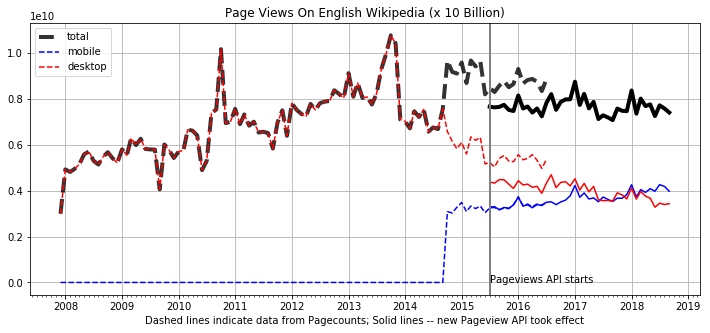

In [51]:
from matplotlib import pyplot as plt

import matplotlib.dates as mdates
import matplotlib.cbook as cbook


# method for automatically adjusting axis ticks to DateTime data
# taken from https://matplotlib.org/gallery/text_labels_and_annotations/date.html
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month

fig, ax = plt.subplots(figsize=(12,5))
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months)

ax.plot(master.pageview_mobile_views, color='blue')
ax.plot(master.pageview_desktop_views, color='red')
ax.plot(master.pageview_all_views, linewidth=4,color='black', label=None)

# for matplotlib handles, add comma after variable name to unpack the single-element tuple
total_traffic, = ax.plot(master.pagecount_all_views, linewidth=4, linestyle='dashed', label='total',color='black',alpha=0.8)
mobile_traffic, = ax.plot(master.pagecount_mobile_views, linestyle='dashed', color='blue', label='mobile')
desktop_traffic, = ax.plot(master.pagecount_desktop_views, label='desktop',linestyle='dashed', color='red', alpha=1)

plt.axvline(datetime(2015,7,1), linewidth=2,color='grey')
plt.text(datetime(2015,7,1),0, "Pageviews API starts",rotation=0)
plt.legend(handles=[total_traffic, mobile_traffic, desktop_traffic], loc='upper left')
plt.grid(True)
plt.title("Page Views On English Wikipedia (x 10 Billion)")
plt.xlabel("Dashed lines indicate data from Pagecounts; Solid lines -- new Pageview API took effect")

# save to png file, and show output 
fig.savefig('english-wikipedia-traffic-2008to2018.png', dpi=fig.dpi)
plt.show() 